#  nCoV-2019 Data Visualization


Fan Wang

July 13 2020

### Data Source:
| Project              | Data description                                         | Subjects | Source              
| :------------------: | :------------------------------------------------------: | :------: | :----------------------------------: |
| open-nCoV2019 (UW) | Epidemiology individual-level line lists around the world | 1083 | University of Washington Institute for Health Metrics and Evaluation|


In this notebook, we are performing some visual analysis on the individual COVID-19 case reports that provide aggregated data on demographic data, geographic location and symptoms. Please note that the data is available from Jan 3, 2020 to April 30, 2020. All results shown in this notebook are for demonstration purposes and should not be considered scientifically rigorous.

### Import libraries

In [1]:
%%capture
# main libraries
! pip install pyecharts -U
! pip install upsetplot
! pip install gen3
import requests, json, fnmatch, os, os.path, sys, subprocess, glob, ntpath, copy, gen3
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission
import pandas as pd
from functools import reduce
# visual libraries
import upsetplot
from upsetplot import UpSet
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
from pyecharts.charts import Map,Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType
# notebook setting
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Use Gen3 SDK to extract clinical data
To extract the data needed, simply export the `demographic` and `observation` node from the Chicagoland Pandemic Response Commons.

In [2]:
api = "https://chicagoland.pandemicresponsecommons.org/"
creds = "credentials_covid.json"
auth = Gen3Auth(api, refresh_file=creds)
sub = Gen3Submission(api, auth)


def get_node_tsvs(node, projects=None, overwrite=False):
    # Get a TSV of the node(s) specified for each project specified
    if not isinstance(node, str):  # Create folder on VM for downloaded files
        mydir = "downloaded_tsvs"
    else:
        mydir = str(node + "_tsvs")
    if not os.path.exists(mydir):
        os.makedirs(mydir)
    if projects is None:  # if no projects specified, get node for all projects
        project_ids = list(
            json_normalize(
                sub.query("""{project (first:0){project_id}}""")["data"]["project"]
            )["project_id"]
        )
    elif isinstance(projects, str):
        projects = [projects]
    dfs = []
    df_len = 0
    for project in projects:
        filename = str(mydir + "/" + project + "_" + node + ".tsv")
        if (os.path.isfile(filename)) and (overwrite is False):
            print("File previously downloaded.")
        else:
            prog, proj = project.split("-", 1)
            sub.export_node(prog, proj, node, "tsv", filename)
        df1 = pd.read_csv(filename, sep="\t", header=0)
        dfs.append(df1)
        df_len += len(df1)
        print(filename + " has " + str(len(df1)) + " records.")
    all_data = pd.concat(dfs, ignore_index=True)
    print("length of all dfs: " + str(df_len))
    nodefile = str("master_" + node + ".tsv")
    all_data.to_csv(str(mydir + "/" + nodefile), sep="\t")
    print(
        "Master node TSV with "
        + str(len(all_data))
        + " total records written to "
        + nodefile
        + "."
    )
    return all_data


# Get subject node tsvs
demographic_nCOV2019 = get_node_tsvs("demographic", "open-nCoV2019")
observation_nCOV2019 = get_node_tsvs("observation", "open-nCoV2019")

File previously downloaded.
demographic_tsvs/open-nCoV2019_demographic.tsv has 1083 records.
length of all dfs: 1083
Master node TSV with 1083 total records written to master_demographic.tsv.
File previously downloaded.
observation_tsvs/open-nCoV2019_observation.tsv has 1083 records.
length of all dfs: 1083
Master node TSV with 1083 total records written to master_observation.tsv.


### Make a Coronavirus world map using nCoV-2019 data
Empowered by `Pyecharts` library

In [3]:
count_table = (
    demographic_nCOV2019.country_region.value_counts()
    .rename_axis("country")
    .reset_index(name="totalcases")
)
count_table = count_table.replace(
    ["UAE", "UK", "USA"], ["United Arab Emirates", "United Kingdom", "United States"]
)
country = list(count_table["country"])
totalcases = list(count_table["totalcases"])

The world map below is a dynamic chart. The number of cases are displayed for each respective location upon mouse hover.

In [4]:
list1 = [[country[i], totalcases[i]] for i in range(len(country))]
map_1 = Map(init_opts=opts.InitOpts(width="1000px", height="500px"))
map_1.add("Total Confirmed Cases", list1, maptype="world", is_map_symbol_show=False)
map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
map_1.set_global_opts(
    visualmap_opts=opts.VisualMapOpts(
        max_=1100000,
        is_piecewise=True,
        pieces=[
            {"min": 150, "max": 199},
            {"min": 100, "max": 149},
            {"min": 50, "max": 99},
            {"min": 30, "max": 49},
            {"min": 20, "max": 29},
            {"min": 10, "max": 19},
            {"min": 1, "max": 9},
        ],
    ),
    title_opts=opts.TitleOpts(
        title="COVID-19 Worldwide Total Cases",
        subtitle="nCoV-2019 Data from Jan 3, 2020 to April 30, 2020",
        pos_left="center",
        padding=0,
        item_gap=2,  # gap between title and subtitle
        title_textstyle_opts=opts.TextStyleOpts(
            color="black", font_weight="bold", font_family="Courier New", font_size=20
        ),
        subtitle_textstyle_opts=opts.TextStyleOpts(
            color="grey", font_weight="bold", font_family="Courier New", font_size=13
        ),
    ),
    legend_opts=opts.LegendOpts(is_show=False),
)

map_1.load_javascript()
map_1.render_notebook()

#### Summary
* COVID-19 started to spread all over the world as of April 30, 2020. One of the best ways to visualize the nCoV-2019 data is by mapping the data to the world map. 

* The early stages of the outbreak was mainly in China and some European countries.

### Visualize the combinations of symptoms in nCoV2019 dataset

In [5]:
demographic_nCOV2019 = demographic_nCOV2019[["age", "subjects.submitter_id"]]
observation_nCOV2019 = observation_nCOV2019[["symptoms", "subjects.submitter_id"]]
nCOV2019 = pd.merge(
    demographic_nCOV2019, observation_nCOV2019, on="subjects.submitter_id", how="inner"
)
ncov2019 = nCOV2019[["age", "symptoms"]].dropna(subset=["symptoms"])

In [6]:
def harmonize_symptoms(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom"], axis=1)
    symptoms = dataframe.columns.tolist()
    symptoms.remove("age")
    for symptom in symptoms:
        dataframe = dataframe.replace({symptom: {0: False, 1: True}})
    return dataframe

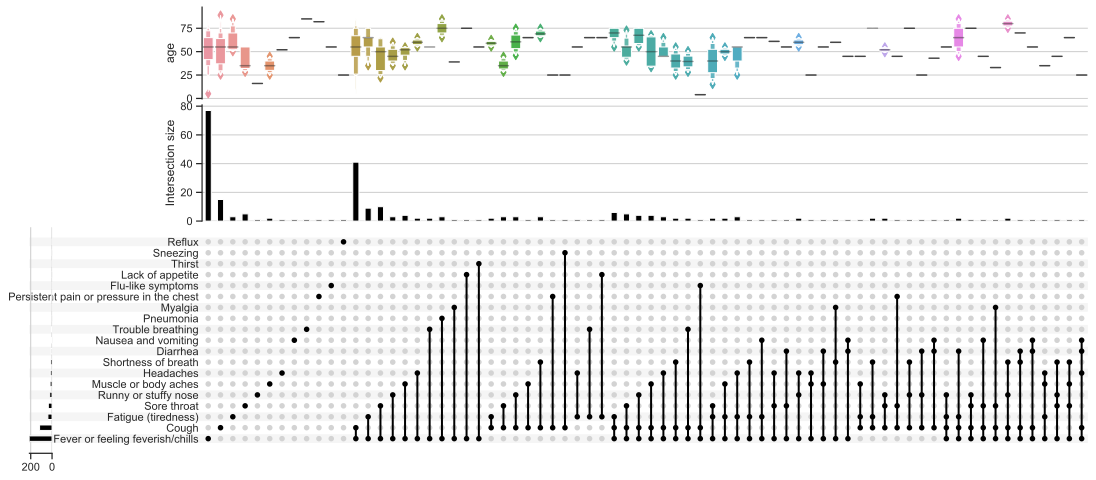

In [7]:
ncov2019_symptom = harmonize_symptoms(ncov2019)
symptoms = ncov2019_symptom.columns.tolist()
symptoms.remove("age")
ncov2019_symptom = ncov2019_symptom.set_index(symptoms)
upset = UpSet(
    ncov2019_symptom, subset_size="count", intersection_plot_elements=10, element_size=16
)
upset.add_catplot(value="age", kind="boxen", elements=8)
upset.plot()
plt.show()

### Calculate the frequencies of symptoms in nCoV2019 dataset

In [8]:
def caculate_symptoms_presence(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom", "age"], axis=1)
    if "no data" in dataframe.columns:
        dataframe = dataframe.drop(["no data"], axis=1)
    else:
        pass
    if "fever* or feeling feverish/chills" in dataframe.columns:
        dataframe = dataframe.drop(["fever* or feeling feverish/chills"], axis=1)
    else:
        pass
    ratio = (dataframe.sum()/dataframe.shape[0]).sort_values(ascending=False)
    return pd.Series(["{0:.2f}%".format(val * 100) for val in ratio], index = ratio.index)

caculate_symptoms_presence(ncov2019)

Fever or feeling feverish/chills            78.52%
Cough                                       43.33%
Fatigue (tiredness)                         14.44%
Sore throat                                 12.96%
Runny or stuffy nose                         8.15%
Muscle or body aches                         6.67%
Headaches                                    5.93%
Shortness of breath                          5.56%
Diarrhea                                     3.70%
Nausea and vomiting                          2.59%
Trouble breathing                            2.22%
Pneumonia                                    1.11%
Myalgia                                      1.11%
Persistent pain or pressure in the chest     1.11%
Flu-like symptoms                            0.74%
Lack of appetite                             0.74%
Thirst                                       0.37%
Sneezing                                     0.37%
Reflux                                       0.37%
dtype: object

#### Summary
* Most common symptoms are fever and cough in this dataset.
* Although this dataset has a sample size of 1083 patients, symptoms data is only available for 270 patients.
* There are a total of 20 symptoms: 

     * Primary symptoms (present in >50% of patients): fever.

     * Symptoms of intermediate incidence (present in 5-49% of patients): cough, fatigue, sore throat, muscle or body aches, headaches, shortness of breath. 
     
     * Rare symptoms (present in <5% of patients): runny or stuffy nose, sputum, diarrhea, nausea and vomiting, trouble breathing, persistent pain or pressure in the chest, pneumonia, myalgia, lack of appetite, flu-like symptoms, reflux, sneezing, thirst.

### Visualize the correlation between symptoms in nCoV2019 dataset

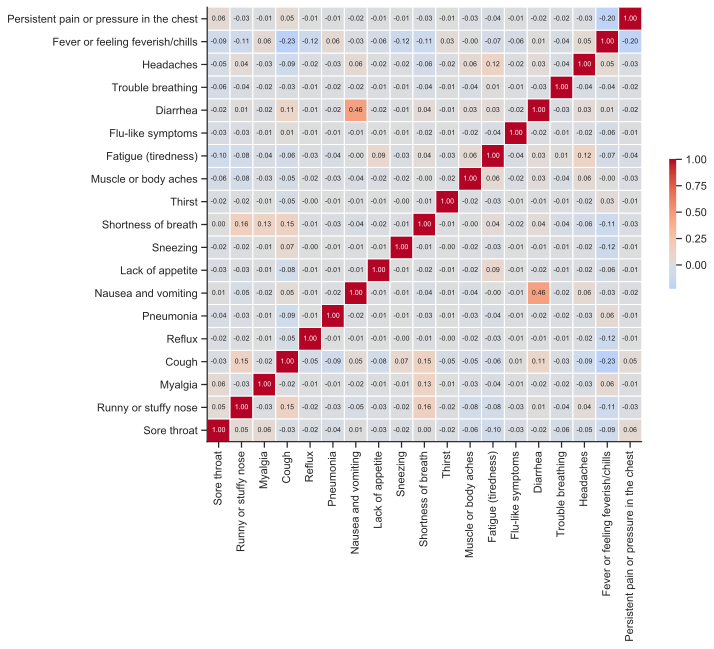

In [9]:
def corr_plot(dataframe):
    dataframe["symptom"] = dataframe["symptoms"].str.split(",")
    for symptom in set.union(*dataframe.symptom.apply(set)):
        dataframe[symptom] = dataframe.apply(
            lambda _: int(symptom in _.symptom), axis=1
        )
    dataframe = dataframe.drop(["symptoms", "symptom", "age"], axis=1)
    if "fever* or feeling feverish/chills" in dataframe.columns:
        dataframe = dataframe.drop(["fever* or feeling feverish/chills"], axis=1)
    else:
        pass
    if "no data" in dataframe.columns:
        dataframe = dataframe.drop(["no data"], axis=1)
    else:
        pass
    corr = dataframe.corr()
    fig = sns.heatmap(
        corr,
        yticklabels=True,
        vmax=1,
        center=0,
        square=True,
        linewidths=1,
        cbar_kws={"shrink": 0.3},
        annot=True,
        fmt=".2f",
        annot_kws={"size": 7},
        cmap="coolwarm",
    )
    sns.despine()
    fig.figure.set_size_inches(10, 8)
    fig.set_ylim(0, len(dataframe.columns))
    return fig


corr_plot(ncov2019)

#### Summary
* High positive correlation was found between diarrhea, nausea and vomiting. These are all gastrointestinal symptoms, which may result from Remdesivir treatment.
* Some respiratory symptoms are correlated: shortness of breath is positively correlated with sputum; cough is positively correlated with sputum.
* Slight negative correlation was observed between fever and cough.
